In [ ]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, GlobalAveragePooling2D
import seaborn as sb
import deepdish as dd
from datahandling import read_wbt, load_wbt, get_clean_wingbeats_multiple_runs
import tensorflow as tf
tf.enable_eager_execution() 

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d2'
nb_classes = 2
# clean = True

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### LOADING DATA

In [3]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [4]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [5]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [6]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    13644
0     9105
dtype: int64

val: 
1    4566
0    3017
dtype: int64

test: 
1    14637
0    12126
dtype: int64


### LOADING MODEL

In [7]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_loss')
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes, extra_dense_layer=False)
model = modelconf.config

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
model.load_weights(f"{TEMP_DATADIR}/Flies_rawflt_conv1d2_custom.h5")
# model.summary()

############ INPUT SHAPE:(5000, 1)


In [9]:
y_scores = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting, binary_labels=True),
                         steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                         verbose=1)

837/837 [==============================] - 20s 24ms/step


In [39]:
df = pd.DataFrame({"x": X_test, "y": y_test, "score0":y_scores[:,0], "score1":y_scores[:,1]})
df['pred'] = np.argmax(y_scores, axis=1)
df["right"] = df.y == df.pred

In [40]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras import backend as K

y_testcat = to_categorical(y_test)

cce = CategoricalCrossentropy(reduction="none")

loss = cce(K.variable(y_testcat), K.variable(y_scores))
df['loss'] = pd.Series(loss.numpy()).round(6)

# How many intermediates do we have
#### Defining the range for intermediates

In [41]:
low = 0.35
high = 0.65

df_uncertain = df[(df.score0 > low) & (df.score0 < high) | (df.score1 > low) & (df.score1 < high)].reset_index().rename(columns={'index': 'index_og'})
print(f"{df_uncertain.shape[0]} within given range")

644 within given range


In [42]:
df_certain = df[~((df.score0 > low) & (df.score0 < high) | (df.score1 > low) & (df.score1 < high))].reset_index().rename(columns={'index': 'index_og'})

In [43]:
clnscore = get_clean_wingbeats_multiple_runs(names=df_uncertain.x.tolist())
df_uncertain['clean_score'] = clnscore

In [44]:
unc_idx_list = df_uncertain.index.to_series().sample(20, replace=False).tolist()

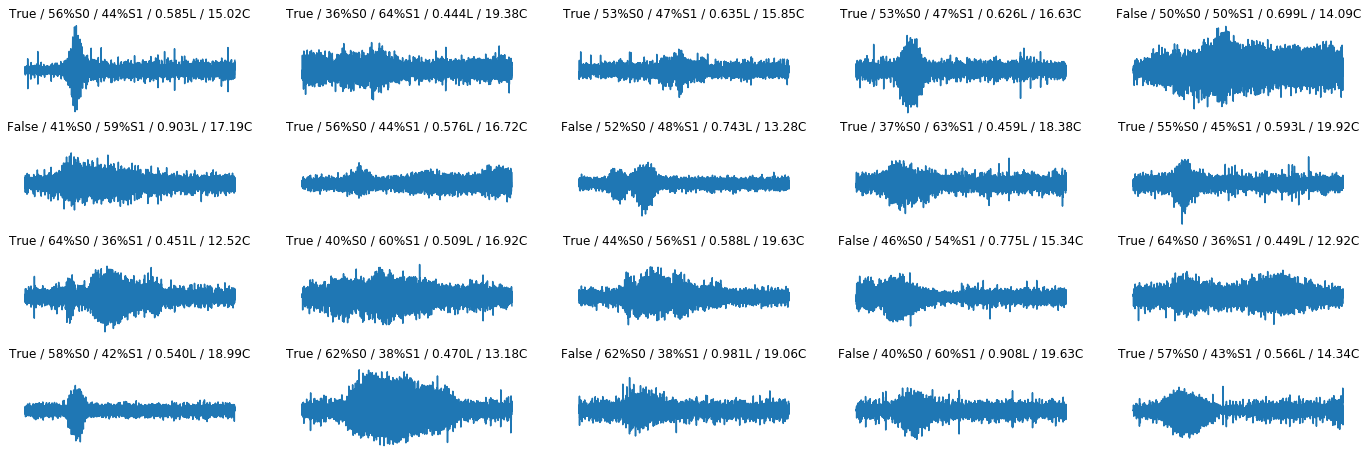

In [76]:
plt.figure(figsize=(24,8))
for i, idx in enumerate(unc_idx_list):
    plt.subplot(4,5,i+1)
    path = df_uncertain.x.loc[idx]
    label = df_uncertain.y.loc[idx]
    right = df_uncertain.right.loc[idx]
    clean_score = df_uncertain.clean_score.loc[idx]
    loss = df_uncertain.loss.loc[idx]
    score0 = df_uncertain.score0.loc[idx]
    score1 = df_uncertain.score1.loc[idx]
    sig = read_wbt(path)
    assert idx in unc_idx_list
    plt.plot(sig)
    plt.axis('off')
    plt.ylim(-.035,.035)
    plt.title(f"{right} / {score0:.0%}S0 / {score1:.0%}S1 / {loss:.3f}L / {clean_score:.2f}C")

In [70]:
correct = df_uncertain.right.sum() / df_uncertain.shape[0]
print(f"{correct:.2%}% correct for the uncertain data points ({df_uncertain.shape[0]} total), average loss: {df_uncertain.loss.mean():.4f}")
correct = df_certain.right.sum() / df_certain.shape[0]
print(f"{correct:.2%}% correct for certain data points ({df_certain.shape[0]} total), average loss: {df_certain.loss.mean():.4f}")

spl = df_certain.sample(650)
correct = spl.right.sum() / spl.shape[0]
print(f"{correct:.2%}% correct for a sample of certain data points ({spl.shape[0]} total), average loss: {spl.loss.mean():.4f}")

correct = df.right.sum() / df.shape[0]
print(f"{correct:.2%}% correct for all data points ({df.shape[0]} total), average loss: {df.loss.mean():.4f}")

52.48%% correct for the uncertain data points (644 total), average loss: 0.6961
94.03%% correct for certain data points (26119 total), average loss: 0.2472
92.46%% correct for a sample of certain data points (650 total), average loss: 0.2891
93.03%% correct for all data points (26763 total), average loss: 0.2580


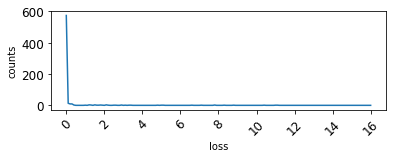

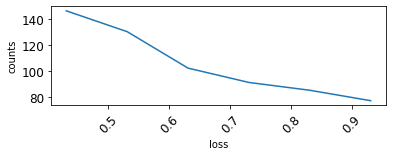

In [58]:
plt.subplot(2,1,1);np_hist(df_certain.sample(df_uncertain.shape[0]),'loss')
plt.subplot(2,1,2);np_hist(df_uncertain,'loss')

In [75]:
zaprionus = DatasetConfiguration(names=['LG'])
zaprionus.select(name='LG', species=['LG_zapr_26_09']); 
zaprionus.read();
print(f"Before cleaning: \n{zaprionus.df.labels.value_counts()}")
zaprionus.clean();
print(f"After cleaning: \n{zaprionus.df.labels.value_counts()}")

Dataset - LG - exists: True
Before cleaning: 
LG_zapr_26_09    7210
Name: labels, dtype: int64
After cleaning: 
LG_zapr_26_09    7022
Name: labels, dtype: int64


In [ ]:
y_scores = model.predict(valid_generator(zaprionus.fnames.tolist(), y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting, binary_labels=True),
                         steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                         verbose=1)